In [ ]:
# prompt: can you open and read cleaned_alldata_version2.csv

import pandas as pd

try:
  data = pd.read_csv('cleaned_alldata_version2.csv')
  print(data.head())
except FileNotFoundError:
  print("File not found. Please make sure the file is in the current directory or provide the correct path.")


   Unnamed: 0 Date_of_observation                      Species_name       Lat  \
0           1          2020-01-01  Indian Almond-Terminalia catappa  12.15386   
1           2          2020-01-01  Indian Almond-Terminalia catappa  12.15386   
2           3          2020-01-01      Fish-tail Palm-Caryota urens  12.14060   
3           4          2020-01-01      Mast Tree-Monoon longifolium  12.14060   
4           5          2020-01-01  Indian Almond-Terminalia catappa  12.14060   

       Long State_name  Leaves_fresh  Leaves_mature  Leaves_old  Flowers_bud  \
0  75.22397     Kerala           2.0            0.0         0.0         -2.0   
1  75.22397     Kerala           2.0            0.0         0.0         -2.0   
2  75.22145     Kerala           0.0            2.0         0.0         -2.0   
3  75.22145     Kerala           1.0            2.0         0.0         -2.0   
4  75.22145     Kerala           0.0            1.0         2.0         -2.0   

   Flowers_open  Flowers_male  F

In [ ]:
# Update the season assignment to ensure any  weeks are reassigned to the closest season
def assign_season_adjusted(week):

    if 9 <= week <= 21:
        return 'Summer'
    elif 22 <= week <= 34:
        return 'Southwest Monsoon'
    elif 40 <= week <= 47:
        return 'Northeast Monsoon'
    elif (48 <= week <= 52) or (0 <= week <= 8):
        return 'Winter'
    else:

        if week < 9:
            return 'Winter'
        elif 35 <= week <= 39:
            return 'Southwest Monsoon'
        elif 38 <= week < 40:
            return 'Northeast Monsoon'
        else:
            return 'Other'


data['Season'] = data['Week'].apply(assign_season_adjusted)




In [ ]:

output_file_path = 'updated_alldata_with_seasons_ver2.csv'


data.to_csv(output_file_path, index=False)

print(f"Data saved to {output_file_path}")


Data saved to updated_alldata_with_seasons_ver2.csv


In [ ]:

species_clusters = {}

# Define seasonal columns for clustering
seasonal_columns = ['Leaves_fresh', 'Leaves_mature', 'Leaves_old', 'Flowers_bud',
                    'Flowers_open', 'Flowers_male', 'Flowers_Female', 'Fruits_unripe',
                    'Fruits_ripe', 'Fruits_open']

# Step 2-4: Iterate over each top species and each year to perform seasonal clustering and store results
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
# Dictionary to store clustering results for each species
species_clusters = {}
top_species = data['Species_name'].value_counts().head(30).index.tolist()

for species in top_species:
    species_clusters[species] = {}


    species_data = data[data['Species_name'] == species]


    for year in species_data['Year'].unique():

        yearly_data = species_data[species_data['Year'] == year]

        seasonal_aggregates = yearly_data.groupby(['Lat', 'Long', 'Season'])[seasonal_columns].mean().reset_index()
        seasonal_aggregates = seasonal_aggregates.fillna(-2)  # Handle missing values as absence

        # Check if the seasonal data is empty
        if seasonal_aggregates.empty:
            continue  # Skip if there's no data for this species and year


        seasonal_data = seasonal_aggregates.drop(['Lat', 'Long', 'Season'], axis=1)
        scaler = StandardScaler()
        seasonal_data_scaled = scaler.fit_transform(seasonal_data)


        dbscan = DBSCAN(eps=1.5, min_samples=10)
        clusters = dbscan.fit_predict(seasonal_data_scaled)

        # Add clusters to the data and store it for analysis
        seasonal_aggregates['Cluster'] = clusters
        species_clusters[species][year] = seasonal_aggregates  # Store results for each year

# Example output: Display clusters for one of the top species in one year to verify successful completion
species_clusters[top_species[0]][2018].head()


,Lat,Long,Season,Leaves_fresh,Leaves_mature,Leaves_old,Flowers_bud,Flowers_open,Flowers_male,Flowers_Female,Fruits_unripe,Fruits_ripe,Fruits_open,Cluster
0,8.33233,77.06117,Winter,1.0,2.0,1.0,0.000000,0.000000,-2.0,-2.0,0.0,0.000000,-2.0,0
1,8.33460,77.05563,Winter,0.0,2.0,1.0,0.333333,0.333333,-2.0,-2.0,0.0,-0.666667,-2.0,0
2,8.33613,77.05932,Winter,1.0,2.0,1.0,0.000000,0.000000,-2.0,-2.0,0.0,0.000000,-2.0,0
3,8.33698,77.04637,Northeast Monsoon,1.0,2.0,1.0,1.000000,1.000000,-2.0,-2.0,1.0,0.000000,-2.0,0
4,8.33698,77.04637,Summer,1.5,2.0,1.0,0.500000,0.500000,-2.0,-2.0,0.5,0.500000,-2.0,0


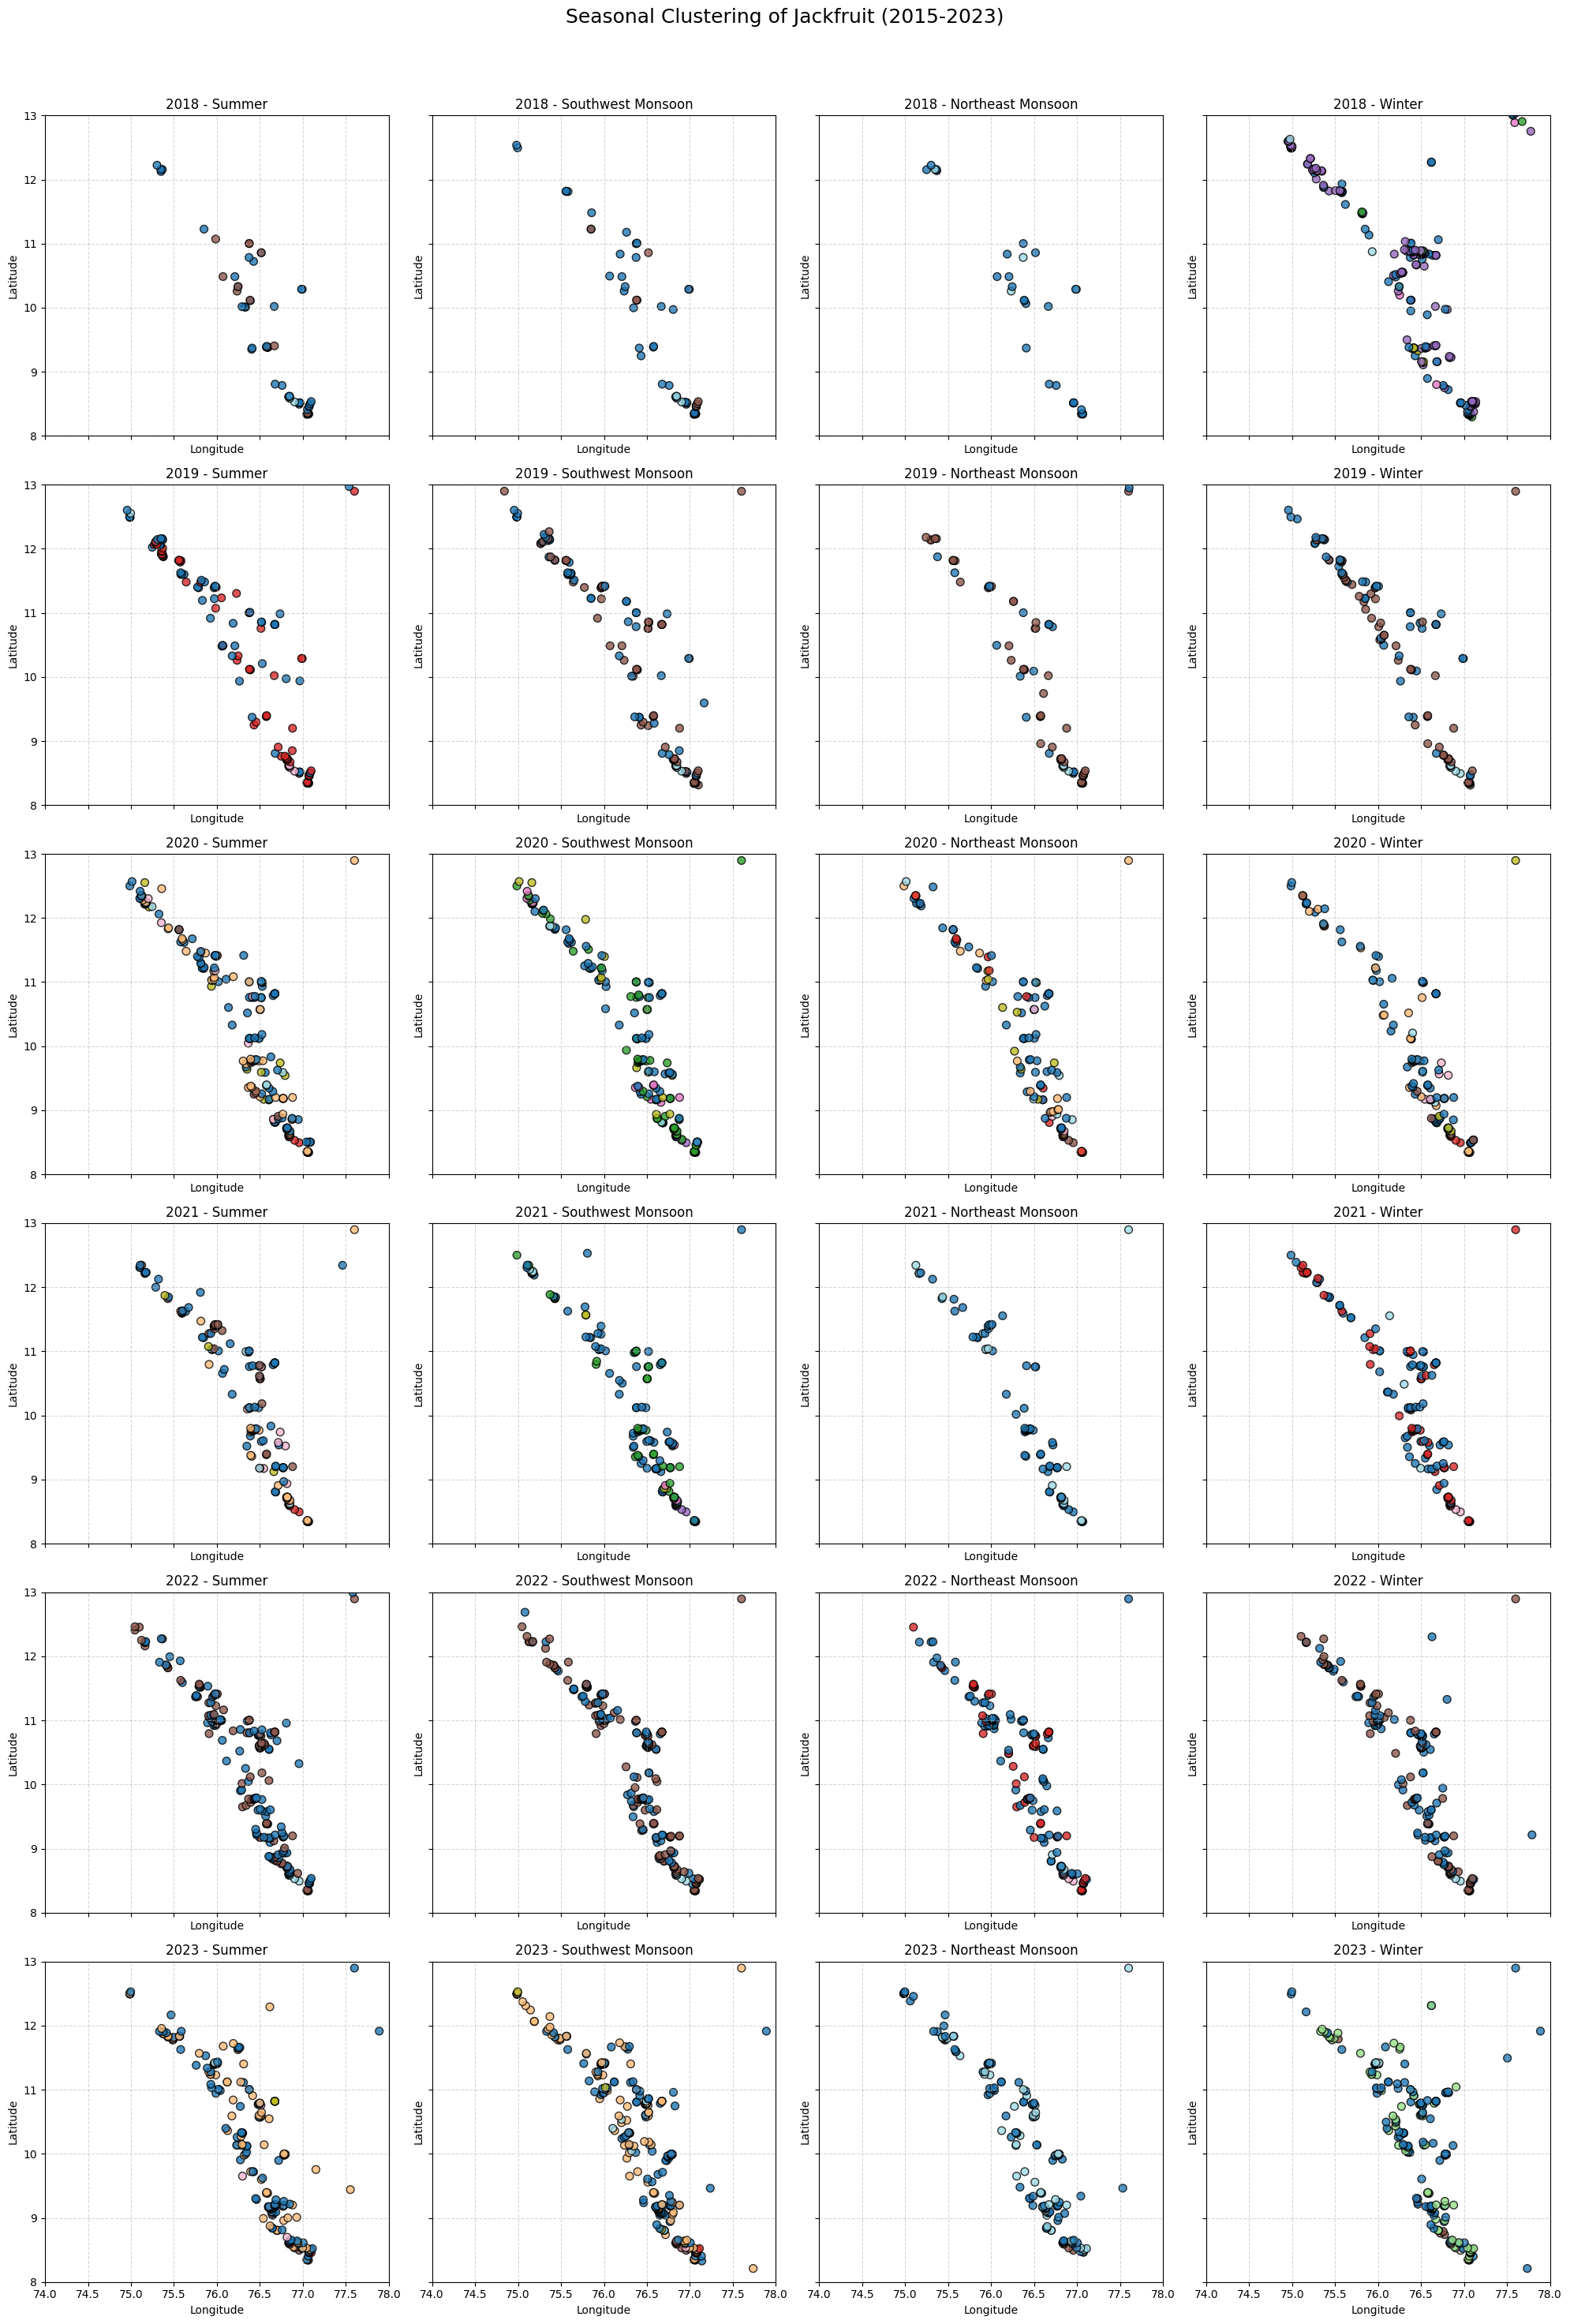

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

jackfruit_data = data[data['Species_name'] == "Jackfruit-Artocarpus heterophyllus"]

seasons = ["Summer", "Southwest Monsoon", "Northeast Monsoon", "Winter"]
seasonal_columns = ['Leaves_fresh', 'Leaves_mature', 'Leaves_old', 'Flowers_bud',
                    'Flowers_open', 'Flowers_male', 'Flowers_Female', 'Fruits_unripe',
                    'Fruits_ripe', 'Fruits_open']

available_years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Collect non-empty plots
non_empty_combinations = []
for year in available_years:
    yearly_data = jackfruit_data[jackfruit_data['Year'] == year]
    for season in seasons:
        season_data = yearly_data[yearly_data['Season'] == season]
        if not season_data.empty:
            non_empty_combinations.append((year, season))

# Determine rows and columns dynamically
ncols = 4  # Fixed number of columns
nrows = (len(non_empty_combinations) // ncols) + (len(non_empty_combinations) % ncols > 0)

fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows * 5), sharex=True, sharey=True)
fig.suptitle("Seasonal Clustering of Jackfruit (2015-2023)", fontsize=18)

# Flatten axes for easy indexing
axs = axs.flatten()

for idx, (year, season) in enumerate(non_empty_combinations):
    yearly_data = jackfruit_data[jackfruit_data['Year'] == year]
    season_data = yearly_data[yearly_data['Season'] == season]

    # Aggregate data by location (Lat, Long)
    season_agg = season_data.groupby(['Lat', 'Long'])[seasonal_columns].mean().reset_index()
    season_agg = season_agg.fillna(-2)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(season_agg[seasonal_columns])

    dbscan = DBSCAN(eps=1.5, min_samples=5)
    season_agg['Cluster'] = dbscan.fit_predict(scaled_data)

    ax = axs[idx]
    scatter = ax.scatter(season_agg['Long'], season_agg['Lat'], c=season_agg['Cluster'], cmap='tab20',
                         s=50, alpha=0.8, edgecolors='k')
    ax.set_title(f"{year} - {season}")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(74, 78)
    ax.set_ylim(8, 13)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Hide unused subplots
for ax in axs[len(non_empty_combinations):]:
    ax.remove()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
